<a href="https://colab.research.google.com/github/ElisaHeinrich/cs146_lba/blob/master/LBA__The_Cost_of_Basic_Goods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Cost of Basic Goods**
### CS146 Location-Based Assigment
---
**Elisa Heinrich Mora**

**Professor Carl Scheffler**





*Does the store brand affect product prices, or not? Are grocery prices and the geographical distribution of different grocery stores correlated with other cost-of-living measures in a city - for example, rent and real estate prices?*

### Questions to answer

*   What is the basic average price for each product? You need to think carefully about how to anchor the basic price for each product since this will depend on the currency used as well as the distirbution of prices.

*   How much does each of the following factors modify the basic price of the product (up or down)?

        -   Brand of the grocery store.
        -   The geographical location of the grocery store.

* Does price variation by geographical location correlate with variation in rantal prices in Buenos Aires, or not?




### Building the model

Implementation is done in PyStan, generating samples from the posterior, presenting the posterior results, and using the posteriors to answer the questions provided. 

The basic idea of the model is that each type of product (apples, bananas, etc.) has a base price, with multipliers depending on store brand and geographical location. 



*   The base price of each product.
        - Price is a positive real number.
        - This is a scale parameter since it depends on the currency used - for example, something that costs 1 Euro would currently cost about 130 Japanese Yen or about 27,000 Vietnamese Dong. So we really do not know the scale of prices a priori.
        - Since we really do not know the scale, use a broad prior over the base price of each product. 

*   The multiplier for each store brand
        - This is a scale parameter (positive real number)
        - The prior should be centered on 1, to achieve an average multiplier of 1. 

*   The multiplier for the geographical location (perhaps using the nearest Metro stop?)
        - This is a scale parameter (positive real number)
        - The prior should also be centered on 1





## **Metadata**

Stores: 

*   Carrefour, No. 276號, Jinzhou Street, Zhongshan District, Taipei City, Taiwan 10477 - ***Visited on March 6th, 2020 at 10 am.*** 

*   Wellcome, No. 71, Tong'an Street, Zhongzheng District, Taipei City, Taiwan 100 - ***Visited on on March 6th, 2020 at 11 am.***




In [50]:
from google.colab import files
from IPython.display import Image

uploaded = files.upload()

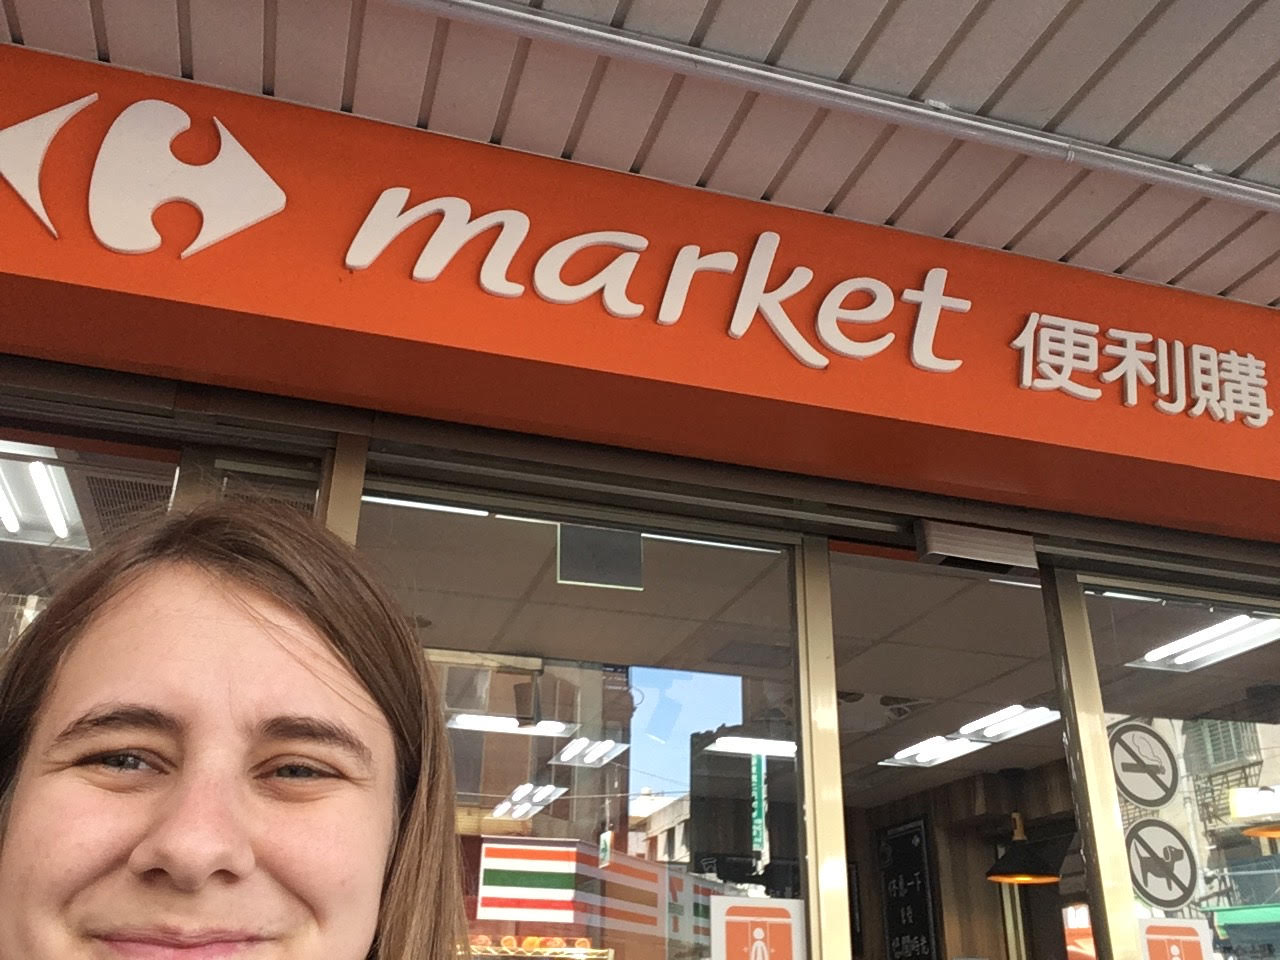

In [51]:
Image("lba1.jpg", width=300)

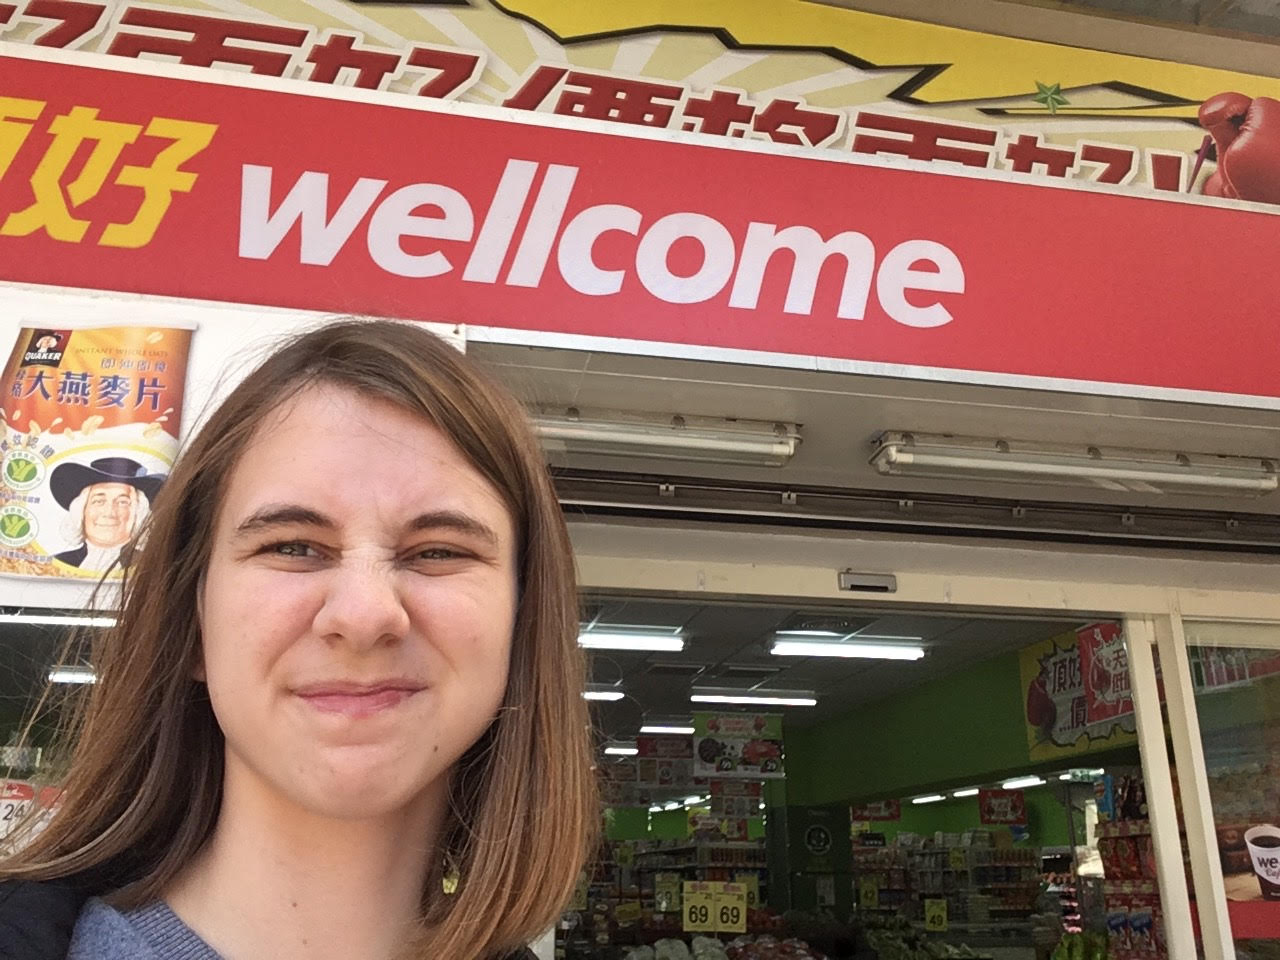

In [52]:
Image("lba2.jpg", width=300)

## Data Cleaning

In [0]:
from scipy import stats as sts
import numpy as np
import matplotlib.pyplot as plt
import pystan
import pandas as pd
import difflib

In [3]:
# Importing general data
data = pd.read_csv("CS146 LBA data gathering (Spring 2020) (Responses) - Form Responses 1.csv")
data.head(5)

,Timestamp,Email Address,Your name,Grocery store,Grocery store street address,Product 1 quantity (kg),Product 1 price,Product 2 quantity (kg),Product 2 price,Product 3 quantity (kg),Product 3 price,Product 1 quantity (kg).1,Product 1 price.1,Product 2 quantity (kg).1,Product 2 price.1,Product 3 quantity (kg).1,Product 3 price.1,Product 1 quantity (kg).2,Product 1 price.2,Product 2 quantity (kg).2,Product 2 price.2,Product 3 quantity (kg).2,Product 3 price.2,Product 1 quantity (kg).3,Product 1 price.3,Product 2 quantity (kg).3,Product 2 price.3,Product 3 quantity (kg).3,Product 3 price.3,Product 1 quantity (kg).4,Product 1 price.4,Product 2 quantity (kg).4,Product 2 price.4,Product 3 quantity (kg).4,Product 3 price.4,Product 1 quantity (kg).5,Product 1 price.5,Product 2 quantity (kg).5,Product 2 price.5,Product 3 quantity (kg).5,Product 3 price.5,Product 1 quantity (liters),Product 1 price.6,Product 2 quantity (liters),Product 2 price.6,Product 3 quantity (liters),Product 3 price.6,Product 1 quantity (kg).6,Product 1 price.7,Product 2 quantity (kg).6,Product 2 price.7,Product 3 quantity (kg).6,Product 3 price.7,Product 1 quantity (count),Product 1 price.8,Product 2 quantity (count),Product 2 price.8,Product 3 quantity (count),Product 3 price.8,Product 1 quantity (kg).7,Product 1 price.9,Product 2 quantity (kg).7,Product 2 price.9,Product 3 quantity (kg).7,Product 3 price.9
0,3/2/2020 19:09:54,antoniostark@minerva.kgi.edu,Antonio Stark,Wellcome,"Wellcome, No. 145, Section 1, Heping East Road...",0.6,198.00,0.4,138.0,1.2,478.0,0.14,20.0,NaN,NaN,NaN,NaN,0.5,158.00,0.5,118.00,0.5,136.0,0.6,118.00,1.0,130.0,1.0,90.0,0.1,21.00,0.1,12.0,1.0,118.00,1.0,253.34,2.5,458.00,1.0,112.66,0.1,17.94,0.1,18.28,0.1,17.86,0.01,16.26,0.1,170.00,0.1,254.4,10.0,190.00,10.0,96.00,10.0,158.00,0.16,198.0,0.25,158.0,0.1,50.0
1,3/2/2020 23:33:15,halkenjo@minerva.kgi.edu,Johannes Halkenhaeusser,Carrefour,"Carrefour Market, Av. Corrientes 1160, 1043 CA...",1.0,69.90,1.0,86.0,1.0,50.0,1.00,94.9,NaN,NaN,NaN,NaN,1.0,84.90,NaN,NaN,NaN,NaN,1.0,26.00,1.0,55.0,1.0,54.9,1.0,46.00,1.0,33.0,1.0,54.90,1.0,53.50,1.0,61.00,1.0,54.50,1.0,40.25,1.0,51.90,1.0,218.50,1.00,545.00,1.0,525.00,1.0,680.0,1.0,9.83,1.0,9.17,1.0,10.25,1.00,239.9,1.00,304.9,NaN,NaN
2,3/2/2020 23:37:17,halkenjo@minerva.kgi.edu,Johannes Halkenhaeusser,Supermercados Día,"Supermercados Día, Av. Corrientes 3534, C1194 ...",1.0,74.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,92.99,1.0,92.99,NaN,NaN,1.0,34.99,NaN,NaN,NaN,NaN,1.0,40.69,NaN,NaN,NaN,NaN,1.0,59.99,1.0,67.98,1.0,49.99,1.0,52.49,1.0,40.25,1.0,68.99,1.00,489.98,1.0,497.45,1.0,532.9,1.0,9.83,1.0,9.17,1.0,11.33,1.00,312.9,NaN,NaN,NaN,NaN
3,3/3/2020 20:18:11,dennis.antela@minerva.kgi.edu,Dennis Antela Martinez,Jumbo,"Jumbo, Av. Santa Fe 4950, C1425 BHY, Buenos Ai...",1.0,80.00,NaN,NaN,NaN,NaN,1.00,84.0,NaN,NaN,NaN,NaN,1.0,99.00,1.0,139.00,1.0,109.0,1.0,44.00,1.0,26.0,1.0,58.0,1.0,40.00,1.0,77.5,1.0,64.00,1.0,54.00,1.0,53.50,1.0,54.50,1.0,69.00,1.0,60.00,1.0,65.00,0.20,125.00,0.2,130.00,0.2,94.0,6.0,92.90,6.0,59.00,6.0,82.90,1.00,293.9,1.00,348.9,NaN,NaN
4,3/4/2020 21:27:02,jasenlo@minerva.kgi.edu,Jasen Lo,Jumbo,"Jumbo, Guardia Vieja 4558, C1192 CABA, Argentina",1.0,69.00,1.0,89.0,1.0,159.0,1.00,84.0,NaN,NaN,NaN,NaN,1.0,99.00,1.0,109.00,1.0,139.0,1.0,39.00,1.0,55.0,NaN,NaN,1.0,83.00,1.0,80.0,1.0,66.89,1.0,53.50,1.0,66.00,1.0,54.30,1.0,40.25,1.0,65.00,1.0,69.00,0.10,69.00,0.2,124.70,0.2,130.0,12.0,185.00,12.0,145.00,12.0,99.00,1.00,372.0,NaN,NaN,NaN,NaN


In [0]:
# Will delete Tony since it is the only data point in San Francisco
data = data[data['Your name'] != 'Tony Zhu']

In [5]:
# Checking data dimensions (we have 19 students in total (not including Tony), times 2 since each one of them has 2 assigned supermarkets) 
data.shape

(38, 65)

In [6]:
# We confirm that the number of unique values matches the number 
# of students in class (19) (except for tony)
data['Your name'].nunique()

19

In [7]:
data['Your name'].unique()

array(['Antonio Stark', 'Johannes Halkenhaeusser',
       'Dennis Antela Martinez', 'Jasen Lo', 'Giovanna Chaves', 'Kay',
       'Elisa Heinrich Mora', 'Zdravko Varbanov', 'Yu-Ang Chang',
       'Yuhao Chen', 'Luis Gonzalez', 'Julia Minichelli',
       'Yong Zheng Xin', 'Ha Nguyen', 'Hung Nguyen', 'Abdul Qadir',
       'Ziad Ahmed Tawfiq', 'Zainab Ahmed', 'Simon Golombek'],
      dtype=object)

In [8]:
# Let's also make sure we have unique values in the Grocery Store column
data['Grocery store'].nunique()

4

In [9]:
# This is great, data does not have false duplicates, very clean :)
data['Grocery store'].unique()

array(['Wellcome', 'Carrefour', 'Supermercados Día', 'Jumbo'],
      dtype=object)

In [10]:
# importing Supermarket data Taipei - Buenos Aires
# Fixing headers 

taipei = pd.read_csv("CS146, Spring 2020, LBA data collection - Taipei supermarkets.csv")
taipei = taipei.iloc[3:]
new_header = taipei.iloc[0]
taipei = taipei[1:]
taipei.columns = new_header

# Taipei will be considered as a neighborhood in this assignment
#SorryTaipei
taipei['Neighborhood'].fillna('Taipei', inplace= True)
taipei.head(3)

3,Student index,Student name (alphabetical),Supermarket,Map location,Estimated travel time (min),Neighborhood
4,3,Antonio,"Wellcome, No. 145, Section 1, Heping East Road...",https://goo.gl/maps/Lo49cw1euuKbGYEu8,10,Taipei
5,3,Antonio,"Carrefour, 100, Taiwan, Taipei City, Zhongzhen...",https://goo.gl/maps/WtGBKxKDMc2bkbnt6,12,Taipei
6,2,Elisa,"Wellcome, No. 71, Tong'an Street, Zhongzheng D...",https://goo.gl/maps/u2N2T3Vevb3GoY6r9,7,Taipei


In [11]:
# Importing buenos aires neighborhoods data
# Fixing the header
bs_as = pd.read_csv("CS146, Spring 2020, LBA data collection - Buenos Aires supermarkets.csv")
bs_as = bs_as.iloc[2:]
new_header = bs_as.iloc[0]
bs_as = bs_as[1:]
bs_as.columns = new_header
bs_as.head(3)

2,Student index,Student name (alphabetical),Supermarket,Map location,Estimated travel time (min),Neighborhood
3,8,Abdul,"Supermercados Día, Av. Rivadavia 1177, C1033 A...",https://goo.gl/maps/smv1MjGE7FmNXqnMA,20,Monserrat
4,8,Abdul,"Supermercados Día, C1426AJS AJS, Amenábar 1145...",https://goo.gl/maps/Q2LsaodSz7U3Jfbf7,40,Colegiales
5,14,Dennis,"Supermercados Día, Buenos Aires, Defensa 748, ...",https://goo.gl/maps/PYDcuuyhLyRBb8b89,33,Monserrat


In [12]:
# Contecatenate both data sets
# Resulting in a dataset with all the data points from Taipei and Bs As
supermarkets = pd.concat([bs_as, taipei])
supermarkets.head(5)

,Student index,Student name (alphabetical),Supermarket,Map location,Estimated travel time (min),Neighborhood
3,8,Abdul,"Supermercados Día, Av. Rivadavia 1177, C1033 A...",https://goo.gl/maps/smv1MjGE7FmNXqnMA,20,Monserrat
4,8,Abdul,"Supermercados Día, C1426AJS AJS, Amenábar 1145...",https://goo.gl/maps/Q2LsaodSz7U3Jfbf7,40,Colegiales
5,14,Dennis,"Supermercados Día, Buenos Aires, Defensa 748, ...",https://goo.gl/maps/PYDcuuyhLyRBb8b89,33,Monserrat
6,14,Dennis,"Jumbo, Av. Santa Fe 4950, C1425 BHY, Buenos Ai...",https://goo.gl/maps/eXftDSMqfvBS6QUM9,35,Palermo
7,5,Ha,"Supermercados Día, Buenos Aires, Raúl Scalabri...",https://goo.gl/maps/P5uY1gCVAMGWBGUW8,40,Palermo


In [13]:
supermarkets.shape

(47, 6)

In [14]:
supermarkets.head(1)

,Student index,Student name (alphabetical),Supermarket,Map location,Estimated travel time (min),Neighborhood
3,8,Abdul,"Supermercados Día, Av. Rivadavia 1177, C1033 A...",https://goo.gl/maps/smv1MjGE7FmNXqnMA,20,Monserrat


In [15]:
data.head(1)

,Timestamp,Email Address,Your name,Grocery store,Grocery store street address,Product 1 quantity (kg),Product 1 price,Product 2 quantity (kg),Product 2 price,Product 3 quantity (kg),Product 3 price,Product 1 quantity (kg).1,Product 1 price.1,Product 2 quantity (kg).1,Product 2 price.1,Product 3 quantity (kg).1,Product 3 price.1,Product 1 quantity (kg).2,Product 1 price.2,Product 2 quantity (kg).2,Product 2 price.2,Product 3 quantity (kg).2,Product 3 price.2,Product 1 quantity (kg).3,Product 1 price.3,Product 2 quantity (kg).3,Product 2 price.3,Product 3 quantity (kg).3,Product 3 price.3,Product 1 quantity (kg).4,Product 1 price.4,Product 2 quantity (kg).4,Product 2 price.4,Product 3 quantity (kg).4,Product 3 price.4,Product 1 quantity (kg).5,Product 1 price.5,Product 2 quantity (kg).5,Product 2 price.5,Product 3 quantity (kg).5,Product 3 price.5,Product 1 quantity (liters),Product 1 price.6,Product 2 quantity (liters),Product 2 price.6,Product 3 quantity (liters),Product 3 price.6,Product 1 quantity (kg).6,Product 1 price.7,Product 2 quantity (kg).6,Product 2 price.7,Product 3 quantity (kg).6,Product 3 price.7,Product 1 quantity (count),Product 1 price.8,Product 2 quantity (count),Product 2 price.8,Product 3 quantity (count),Product 3 price.8,Product 1 quantity (kg).7,Product 1 price.9,Product 2 quantity (kg).7,Product 2 price.9,Product 3 quantity (kg).7,Product 3 price.9
0,3/2/2020 19:09:54,antoniostark@minerva.kgi.edu,Antonio Stark,Wellcome,"Wellcome, No. 145, Section 1, Heping East Road...",0.6,198.0,0.4,138.0,1.2,478.0,0.14,20.0,NaN,NaN,NaN,NaN,0.5,158.0,0.5,118.0,0.5,136.0,0.6,118.0,1.0,130.0,1.0,90.0,0.1,21.0,0.1,12.0,1.0,118.0,1.0,253.34,2.5,458.0,1.0,112.66,0.1,17.94,0.1,18.28,0.1,17.86,0.01,16.26,0.1,170.0,0.1,254.4,10.0,190.0,10.0,96.0,10.0,158.0,0.16,198.0,0.25,158.0,0.1,50.0


In [16]:
'''
Now we should merge these two data frames
We should finally have one data set with 38 rows
in which we can merge the product information 
with their respective store and neighborhood.

We can do this by observing the Grocery store street address column
in the data dataframe, and the Supermarket columnn in the Supermarkets dataframe

'''

data['Grocery store street address'].nunique()

38

In [17]:
'''
We can observe that some of the data does not start with the Supermarket name
this can be problemative when trying to merge with the other datafrmae
Something positive is that the rest of the address seems to match with the column 
in the other dataset.

'''

data['Grocery store street address'].unique()

array(['Wellcome, No. 145, Section 1, Heping East Road, Da’an District, Taipei City, Taiwan 106',
       'Carrefour Market, Av. Corrientes 1160, 1043 CABA, Argentina',
       'Supermercados Día, Av. Corrientes 3534, C1194 AAO, Buenos Aires, Argentina',
       'Jumbo, Av. Santa Fe 4950, C1425 BHY, Buenos Aires, Argentina',
       'Jumbo, Guardia Vieja 4558, C1192 CABA, Argentina',
       'Supermercados Día, Buenos Aires, Paraguay 788, C1057 AAJ, Argentina',
       ' Supermercados Día, Buenos Aires, Defensa 748, C1065 AAN, Argentina',
       '235, New Taipei City, Zhonghe District, Section 2, Zhongshan Road, 295號B1',
       'Wellcome, 106, Taiwan, Taipei City, Da’an District, Section 3, Roosevelt Rd, 285號',
       'Carrefour, No. 1, Guilin Road, Wanhua District, Taipei City, Taiwan 108',
       'Carrefour, 100, Taiwan, Taipei City, Zhongzheng District, Section 2, Jinan Road, 46號B1',
       'Carrefour, No. 276號, Jinzhou Street, Zhongshan District, Taipei City, Taiwan 10477',
       "Wellc

In [18]:
'''
The reason why we have more rows here is because the professor offered some extra 
options to choose for students in case that the assigned was inconvenient.

'''

print(supermarkets['Supermarket'].nunique())
supermarkets['Supermarket'].unique()

47


array(['Supermercados Día, Av. Rivadavia 1177, C1033 AAB, Buenos Aires, Argentina',
       'Supermercados Día, C1426AJS AJS, Amenábar 1145, C1426 Buenos Aires, Argentina',
       'Supermercados Día, Buenos Aires, Defensa 748, C1065 AAN, Argentina',
       'Jumbo, Av. Santa Fe 4950, C1425 BHY, Buenos Aires, Argentina',
       'Supermercados Día, Buenos Aires, Raúl Scalabrini Ortíz 3170, C1425 DBZ, Argentina',
       'Carrefour Market, Raúl Scalabrini Ortíz 3128, C1425 CABA, Argentina',
       'Carrefour Market, Av. Córdoba 2529, C1120 CABA, Argentina',
       'Jumbo, Av. Gral. Las Heras 2564, C1425 CABA, Argentina',
       'Supermercados Día, Buenos Aires, Paraguay 788, C1057 AAJ, Argentina',
       'Jumbo, Guardia Vieja 4558, C1192 CABA, Argentina',
       'Carrefour Market, Av. Corrientes 1160, 1043 CABA, Argentina',
       'Supermercados Día, Av. Corrientes 3534, C1194 AAO, Buenos Aires, Argentina',
       'Supermercados Día, C1416DRC, Av. Gaona 1290, Buenos Aires, Argentina',
      

In [0]:
'''
for this we can create a function that gets the closest match of a string
Return a list of the best “good enough” matches. 
word is a string for which close matches are desired,
and possibilities is a list of sequences against which to match word.
n is the maximum number of close matches to return, in this case 1.
If we do not fin close match we will return none

Thanks to Nikesh for the idea of using this specific function and library.
'''

def match_address(word, possibilities):
    match = difflib.get_close_matches(word, possibilities, n=1)
    if len(match) == 0: match.append('None')
    return match[0]

In [0]:
data['Grocery store street address']= data['Grocery store street address'].apply(lambda x: match_address(x, supermarkets['Supermarket']))

In [21]:
data['Grocery store street address']

0     Wellcome, No. 145, Section 1, Heping East Road...
1     Carrefour Market, Av. Corrientes 1160, 1043 CA...
2     Supermercados Día, Av. Corrientes 3534, C1194 ...
3     Jumbo, Av. Santa Fe 4950, C1425 BHY, Buenos Ai...
4      Jumbo, Guardia Vieja 4558, C1192 CABA, Argentina
5     Supermercados Día, Buenos Aires, Paraguay 788,...
6     Supermercados Día, Buenos Aires, Defensa 748, ...
7     Carrefour, 235, Taiwan, New Taipei City, Zhong...
8     Wellcome, 106, Taiwan, Taipei City, Da’an Dist...
9     Carrefour, No. 1, Guilin Road, Wanhua District...
10    Carrefour, 100, Taiwan, Taipei City, Zhongzhen...
11    Carrefour, No. 276號, Jinzhou Street, Zhongshan...
12    Wellcome, No. 71, Tong'an Street, Zhongzheng D...
13    Wellcome, 106, Taiwan, Taipei City, Da’an Dist...
14    Carrefour, No. 499-1, Zhonghe Road, Yonghe Dis...
15    Supermercados Día, Buenos Aires AR, Sarmiento ...
16    Wellcome, No. 129, Shida Road, Da’an District,...
17           Jumbo, Arenales 870, C1061 CABA, Ar

In [22]:
# Lets check who is the misterious person who does not match the supermarket
list(data[data['Grocery store street address']== 'None']['Your name'])

['Julia Minichelli']

In [0]:
# We will just manually update this address since it is just one data point
data.at[23, 'Grocery store street address'] = 'Supermercados Día, C1416DRC, Av. Gaona 1290, Buenos Aires, Argentina'

In [0]:
# Renaming columns
data = data.rename(columns = {"Your name": "Student", "Grocery store street address": "Supermarket"})

In [0]:
# Finally we can merge all the data points
full_data = data.merge(supermarkets, on = 'Supermarket')

In [26]:
print(len(full_data))
full_data.head(1)

38


,Timestamp,Email Address,Student,Grocery store,Supermarket,Product 1 quantity (kg),Product 1 price,Product 2 quantity (kg),Product 2 price,Product 3 quantity (kg),Product 3 price,Product 1 quantity (kg).1,Product 1 price.1,Product 2 quantity (kg).1,Product 2 price.1,Product 3 quantity (kg).1,Product 3 price.1,Product 1 quantity (kg).2,Product 1 price.2,Product 2 quantity (kg).2,Product 2 price.2,Product 3 quantity (kg).2,Product 3 price.2,Product 1 quantity (kg).3,Product 1 price.3,Product 2 quantity (kg).3,Product 2 price.3,Product 3 quantity (kg).3,Product 3 price.3,Product 1 quantity (kg).4,Product 1 price.4,Product 2 quantity (kg).4,Product 2 price.4,Product 3 quantity (kg).4,Product 3 price.4,Product 1 quantity (kg).5,Product 1 price.5,Product 2 quantity (kg).5,Product 2 price.5,Product 3 quantity (kg).5,Product 3 price.5,Product 1 quantity (liters),Product 1 price.6,Product 2 quantity (liters),Product 2 price.6,Product 3 quantity (liters),Product 3 price.6,Product 1 quantity (kg).6,Product 1 price.7,Product 2 quantity (kg).6,Product 2 price.7,Product 3 quantity (kg).6,Product 3 price.7,Product 1 quantity (count),Product 1 price.8,Product 2 quantity (count),Product 2 price.8,Product 3 quantity (count),Product 3 price.8,Product 1 quantity (kg).7,Product 1 price.9,Product 2 quantity (kg).7,Product 2 price.9,Product 3 quantity (kg).7,Product 3 price.9,Student index,Student name (alphabetical),Map location,Estimated travel time (min),Neighborhood
0,3/2/2020 19:09:54,antoniostark@minerva.kgi.edu,Antonio Stark,Wellcome,"Wellcome, No. 145, Section 1, Heping East Road...",0.6,198.0,0.4,138.0,1.2,478.0,0.14,20.0,NaN,NaN,NaN,NaN,0.5,158.0,0.5,118.0,0.5,136.0,0.6,118.0,1.0,130.0,1.0,90.0,0.1,21.0,0.1,12.0,1.0,118.0,1.0,253.34,2.5,458.0,1.0,112.66,0.1,17.94,0.1,18.28,0.1,17.86,0.01,16.26,0.1,170.0,0.1,254.4,10.0,190.0,10.0,96.0,10.0,158.0,0.16,198.0,0.25,158.0,0.1,50.0,3,Antonio,https://goo.gl/maps/Lo49cw1euuKbGYEu8,10,Taipei


In [27]:
# Now we can first delete unnecessary columns from the data dataset
full_data = full_data.drop(columns = ['Timestamp', 'Email Address', 'Student index', 'Student name (alphabetical)', 'Map location', 'Estimated travel time (min)'])
full_data.head(1)

,Student,Grocery store,Supermarket,Product 1 quantity (kg),Product 1 price,Product 2 quantity (kg),Product 2 price,Product 3 quantity (kg),Product 3 price,Product 1 quantity (kg).1,Product 1 price.1,Product 2 quantity (kg).1,Product 2 price.1,Product 3 quantity (kg).1,Product 3 price.1,Product 1 quantity (kg).2,Product 1 price.2,Product 2 quantity (kg).2,Product 2 price.2,Product 3 quantity (kg).2,Product 3 price.2,Product 1 quantity (kg).3,Product 1 price.3,Product 2 quantity (kg).3,Product 2 price.3,Product 3 quantity (kg).3,Product 3 price.3,Product 1 quantity (kg).4,Product 1 price.4,Product 2 quantity (kg).4,Product 2 price.4,Product 3 quantity (kg).4,Product 3 price.4,Product 1 quantity (kg).5,Product 1 price.5,Product 2 quantity (kg).5,Product 2 price.5,Product 3 quantity (kg).5,Product 3 price.5,Product 1 quantity (liters),Product 1 price.6,Product 2 quantity (liters),Product 2 price.6,Product 3 quantity (liters),Product 3 price.6,Product 1 quantity (kg).6,Product 1 price.7,Product 2 quantity (kg).6,Product 2 price.7,Product 3 quantity (kg).6,Product 3 price.7,Product 1 quantity (count),Product 1 price.8,Product 2 quantity (count),Product 2 price.8,Product 3 quantity (count),Product 3 price.8,Product 1 quantity (kg).7,Product 1 price.9,Product 2 quantity (kg).7,Product 2 price.9,Product 3 quantity (kg).7,Product 3 price.9,Neighborhood
0,Antonio Stark,Wellcome,"Wellcome, No. 145, Section 1, Heping East Road...",0.6,198.0,0.4,138.0,1.2,478.0,0.14,20.0,NaN,NaN,NaN,NaN,0.5,158.0,0.5,118.0,0.5,136.0,0.6,118.0,1.0,130.0,1.0,90.0,0.1,21.0,0.1,12.0,1.0,118.0,1.0,253.34,2.5,458.0,1.0,112.66,0.1,17.94,0.1,18.28,0.1,17.86,0.01,16.26,0.1,170.0,0.1,254.4,10.0,190.0,10.0,96.0,10.0,158.0,0.16,198.0,0.25,158.0,0.1,50.0,Taipei


In [28]:
'''
We can normalize our prices of each item by dividing the quantity by
its price.

In the original data frame, each item has 6 columns,
     3 first alternates are the quantity
     3 second alternates are the price
and follows the same order as expressed below. 

We need to convert this into 3 columns for each item


'''
supermarket_items = ['Apples', 
                     'Bananas',
                     'Tomatoes',
                     'Potatoes',
                     'Flour, white', 
                     'Rice, basmati', 
                     'Milk, full cream', 
                     'Butter',
                     'Eggs', 
                     'Chicken breasts']

data_items = pd.DataFrame()
quant_idx = 3
price_idx = 4

for i in range(len(supermarket_items)): 
    item = supermarket_items[i]

    for j in range(3):
        title = '-'.join([item, str(j)])
        data_items[title] = full_data.iloc[:,price_idx] / full_data.iloc[:,quant_idx] 

        quant_idx +=2
        price_idx +=2


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [29]:
data_items.head(3)

,Apples-0,Apples-1,Apples-2,Bananas-0,Bananas-1,Bananas-2,Tomatoes-0,Tomatoes-1,Tomatoes-2,Potatoes-0,Potatoes-1,Potatoes-2,"Flour, white-0","Flour, white-1","Flour, white-2","Rice, basmati-0","Rice, basmati-1","Rice, basmati-2","Milk, full cream-0","Milk, full cream-1","Milk, full cream-2",Butter-0,Butter-1,Butter-2,Eggs-0,Eggs-1,Eggs-2,Chicken breasts-0,Chicken breasts-1,Chicken breasts-2
0,330.00,345.0,398.333333,142.857143,NaN,NaN,316.00,236.00,272.0,196.666667,130.0,90.0,210.00,120.0,118.0,253.34,183.20,112.66,179.40,182.80,178.60,1626.00,1700.00,2544.0,19.00,9.60,15.80,1237.5,632.0,500.0
1,69.90,86.0,50.000000,94.900000,NaN,NaN,84.90,NaN,NaN,26.000000,55.0,54.9,46.00,33.0,54.9,53.50,61.00,54.50,40.25,51.90,218.50,545.00,525.00,680.0,9.83,9.17,10.25,239.9,304.9,NaN
2,74.99,NaN,NaN,NaN,NaN,NaN,92.99,92.99,NaN,34.990000,NaN,NaN,40.69,NaN,NaN,59.99,67.98,49.99,52.49,40.25,68.99,489.98,497.45,532.9,9.83,9.17,11.33,312.9,NaN,NaN


In [42]:
'''
Now we have a dataframe with info related to the store, neighborhoods
and the normalized prices of the products.

'''
df1 = full_data[['Grocery store','Neighborhood']]
full_df = pd.concat([df1, data_items], axis=1)
full_df.head(5)

,Grocery store,Neighborhood,Apples-0,Apples-1,Apples-2,Bananas-0,Bananas-1,Bananas-2,Tomatoes-0,Tomatoes-1,Tomatoes-2,Potatoes-0,Potatoes-1,Potatoes-2,"Flour, white-0","Flour, white-1","Flour, white-2","Rice, basmati-0","Rice, basmati-1","Rice, basmati-2","Milk, full cream-0","Milk, full cream-1","Milk, full cream-2",Butter-0,Butter-1,Butter-2,Eggs-0,Eggs-1,Eggs-2,Chicken breasts-0,Chicken breasts-1,Chicken breasts-2
0,Wellcome,Taipei,330.00,345.0,398.333333,142.857143,NaN,NaN,316.00,236.00,272.0,196.666667,130.0,90.0,210.00,120.0,118.00,253.34,183.20,112.66,179.40,182.80,178.60,1626.00,1700.00,2544.0,19.000000,9.600000,15.800000,1237.5,632.0,500.0
1,Carrefour,Retiro,69.90,86.0,50.000000,94.900000,NaN,NaN,84.90,NaN,NaN,26.000000,55.0,54.9,46.00,33.0,54.90,53.50,61.00,54.50,40.25,51.90,218.50,545.00,525.00,680.0,9.830000,9.170000,10.250000,239.9,304.9,NaN
2,Supermercados Día,Almagro,74.99,NaN,NaN,NaN,NaN,NaN,92.99,92.99,NaN,34.990000,NaN,NaN,40.69,NaN,NaN,59.99,67.98,49.99,52.49,40.25,68.99,489.98,497.45,532.9,9.830000,9.170000,11.330000,312.9,NaN,NaN
3,Jumbo,Palermo,80.00,NaN,NaN,84.000000,NaN,NaN,99.00,139.00,109.0,44.000000,26.0,58.0,40.00,77.5,64.00,54.00,53.50,54.50,69.00,60.00,65.00,625.00,650.00,470.0,15.483333,9.833333,13.816667,293.9,348.9,NaN
4,Jumbo,Almagro,69.00,89.0,159.000000,84.000000,NaN,NaN,99.00,109.00,139.0,39.000000,55.0,NaN,83.00,80.0,66.89,53.50,66.00,54.30,40.25,65.00,69.00,690.00,623.50,650.0,15.416667,12.083333,8.250000,372.0,NaN,NaN


In [58]:
'''
We can convert the headers into rows
As we can see we have all the same type of a product 
That will be 32 Apples - 0, 32 Apple -1 and so on

As we can see there are 30 types of products 
therefore, the list will repeat 30 times
'''
reverse_df = pd.melt(data_items).rename(
    columns={"variable":"Product", "value":"Price"}).head()

neighborhood_column = list(full_df.Neighborhood.values.astype(str))*data_items.shape[1]
stores_column = list(full_df['Grocery store'].values.astype(str))*data_items.shape[1]

# Merging all these we have 
df_full = pd.concat([reverse_df,
                     pd.DataFrame({'Neighborhood' : neighborhood_column}), 
                     pd.DataFrame({'Store' : stores_column})], axis =1

)

df_full.head()

,Product,Price,Neighborhood,Store
0,Apples-0,330.00,Taipei,Wellcome
1,Apples-0,69.90,Retiro,Carrefour
2,Apples-0,74.99,Almagro,Supermercados Día
3,Apples-0,80.00,Palermo,Jumbo
4,Apples-0,69.00,Almagro,Jumbo


In [0]:
'''
Now we can create a data frame for each of the relevant 
variables with their respective indexes

'''
Stores = list(full_data['Grocery store'].unique())
Neighborhoods = list(full_data['Neighborhood'].unique())
Supermarket_Items = supermarket_items

def new_dataframes(list_, title):
    df= pd.DataFrame({title: list_})
    df['Index'] = np.arange(len(df))
    return df

data_Stores= new_dataframes(Stores, 'Stores')
data_Neighborhoods= new_dataframes(Neighborhoods, 'Neighborhoods')
data_Supermarket_Items= new_dataframes(Supermarket_Items, 'Supermarket_Items')

In [32]:
data_Stores

,Stores,Index
0,Wellcome,0
1,Carrefour,1
2,Supermercados Día,2
3,Jumbo,3


In [33]:
data_Neighborhoods 

,Neighborhoods,Index
0,Taipei,0
1,Retiro,1
2,Almagro,2
3,Palermo,3
4,Monserrat,4
5,Recoleta,5
6,Caballito,6
7,Colegiales,7
8,Balvanera,8


In [34]:
data_Supermarket_Items

,Supermarket_Items,Index
0,Apples,0
1,Bananas,1
2,Tomatoes,2
3,Potatoes,3
4,"Flour, white",4
5,"Rice, basmati",5
6,"Milk, full cream",6
7,Butter,7
8,Eggs,8
9,Chicken breasts,9


In [61]:
df_full.head()

,Product,Price,Neighborhood,Store
0,Apples-0,330.00,Taipei,Wellcome
1,Apples-0,69.90,Retiro,Carrefour
2,Apples-0,74.99,Almagro,Supermercados Día
3,Apples-0,80.00,Palermo,Jumbo
4,Apples-0,69.00,Almagro,Jumbo


In [0]:
'''
Next step is to convert the strings into int values for better data process
For this we will be using the dataframe with inputs that we obtained before
and match those values into our dataframe

'''
for i in range(df_full.shape[0]):
    



